In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

In [6]:
# %% Simulation parameters
ds = 0.4

F = 0.6
N = 10

radius_of_particle = 0.0165

s = f"{F}_{N}"

file_cfd = f"data/unscaled_p/TrP4_{s}.csv"
file_pinn = f"results/csv/pred_{s}.csv"

In [7]:
tilt = ds / N
radius = F * ds / 2
y_s = radius + radius_of_particle + 0.004
wall_distance_threshold = radius_of_particle

# Define pillar centers
centers = [(0, 0), (0, ds), (ds, tilt), (ds, ds + tilt)]

# Create wall distance grid and gradient interpolators
x_range = np.linspace(0, ds, 400)
y_range = np.linspace(0, ds + tilt, 400)
X, Y = np.meshgrid(x_range, y_range)
distances = np.full_like(X, np.inf, dtype=float)

for cx, cy in centers:
    d = np.sqrt((X - cx)**2 + (Y - cy)**2) - radius
    distances = np.minimum(distances, d)
distances = np.maximum(distances, 0)

# Compute surface normal vectors
dy, dx = np.gradient(distances, y_range, x_range)
grad_mag = np.sqrt(dx**2 + dy**2)
normal_x = np.zeros_like(dx)
normal_y = np.zeros_like(dy)
nonzero = grad_mag > 0
normal_x[nonzero] = dx[nonzero] / grad_mag[nonzero]
normal_y[nonzero] = dy[nonzero] / grad_mag[nonzero]

# Create interpolators
wall_distance_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), distances.ravel(), fill_value=np.inf)
normal_x_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_x.ravel(), fill_value=0)
normal_y_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_y.ravel(), fill_value=0)

# %% Common velocity and RK4 functions
def velocity(x, y, u_interp, v_interp):
    return u_interp(x, y), v_interp(x, y)

def rk4_step(x, y, dt, u, v, u_interp, v_interp):
    k1x = dt * u
    k1y = dt * v
    u2, v2 = velocity(x + k1x / 2, y + k1y / 2, u_interp, v_interp)
    k2x = dt * u2
    k2y = dt * v2
    u3, v3 = velocity(x + k2x / 2, y + k2y / 2, u_interp, v_interp)
    k3x = dt * u3
    k3y = dt * v3
    u4, v4 = velocity(x + k3x, y + k3y, u_interp, v_interp)
    k4x = dt * u4
    k4y = dt * v4
    x_next = x + (k1x + 2*k2x + 2*k3x + k4x) / 6
    y_next = y + (k1y + 2*k2y + 2*k3y + k4y) / 6
    return x_next, y_next

# %% Trajectory simulation function
def simulate_trajectory(file_path, label):
    data = pd.read_csv(file_path)
    x, y, u, v = data['x'].values, data['y'].values, data['u'].values, data['v'].values
    max_vel = max(np.max(np.abs(u)), np.max(np.abs(v)))
    u_interp = LinearNDInterpolator(list(zip(x, y)), u / max_vel)
    v_interp = LinearNDInterpolator(list(zip(x, y)), v / max_vel)

    x0, y0 = 0, y_s
    x_traj, y_traj = [x0], [y0]
    u, v = velocity(x0, y0, u_interp, v_interp)
    dt = 0.05
    i = 0

    while x_traj[-1] < ds - 0.00001 and y_traj[-1] > 0.00001:
        x_next, y_next = rk4_step(x_traj[-1], y_traj[-1], dt, u, v, u_interp, v_interp)
        d_wall = wall_distance_interp(x_next, y_next)

        if d_wall <= wall_distance_threshold:
            nx, ny = normal_x_interp(x_next, y_next), normal_y_interp(x_next, y_next)
            dot = u * nx + v * ny
            u = u - 2 * dot * nx
            v = v - 2 * dot * ny
            x_next += (wall_distance_threshold - d_wall) * nx
            y_next += (wall_distance_threshold - d_wall) * ny
        else:
            u, v = velocity(x_next, y_next, u_interp, v_interp)

        x_traj.append(x_next)
        y_traj.append(y_next)

        i += 1
        if i % 100 == 0:
            print(f"[{label}] Iteration {i}: x = {x_next:.3f}, y = {y_next:.3f}, dist = {d_wall:.4f}, u = {u:.5f}, v = {v:.5f}")
    return x_traj, y_traj

In [8]:
x_cfd, y_cfd = simulate_trajectory(file_cfd, "CFD")
x_pinn, y_pinn = simulate_trajectory(file_pinn, "PINN")

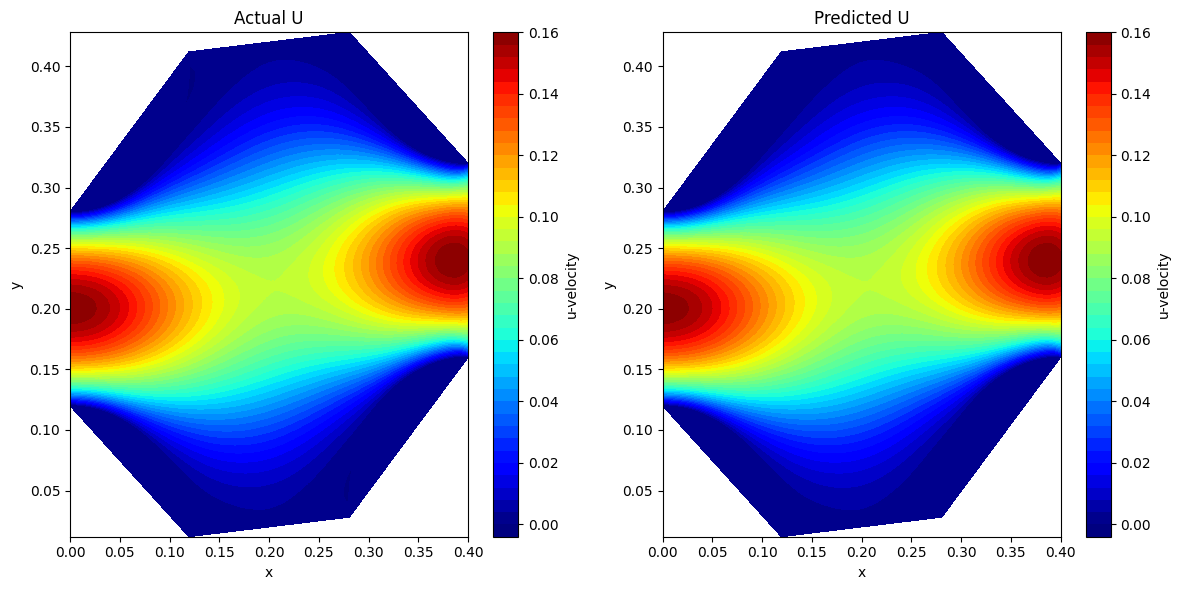

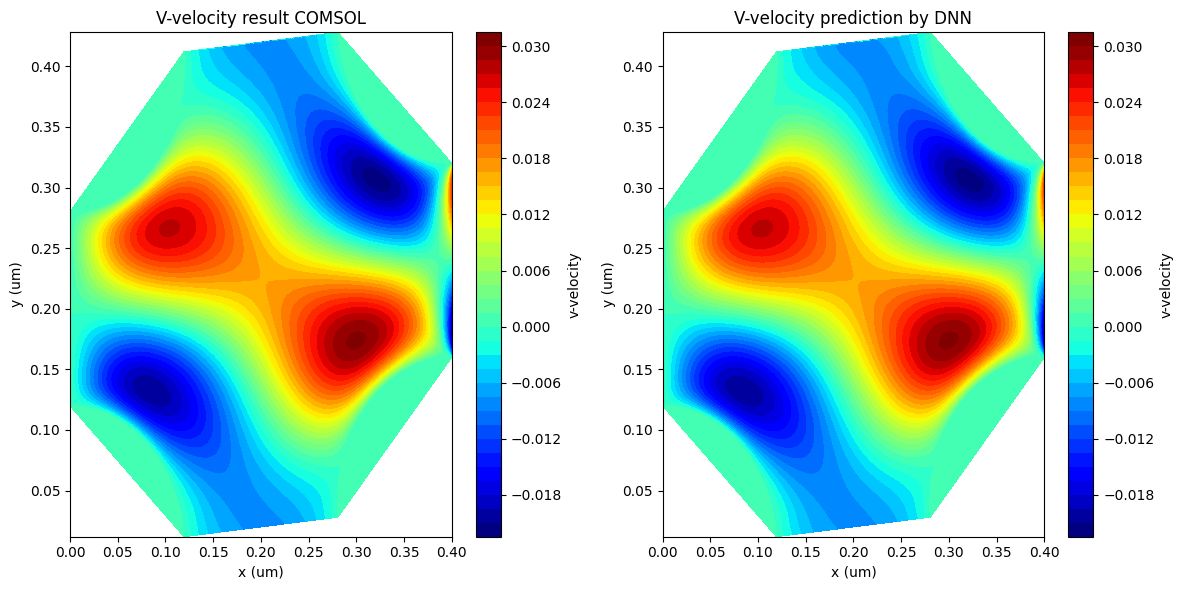

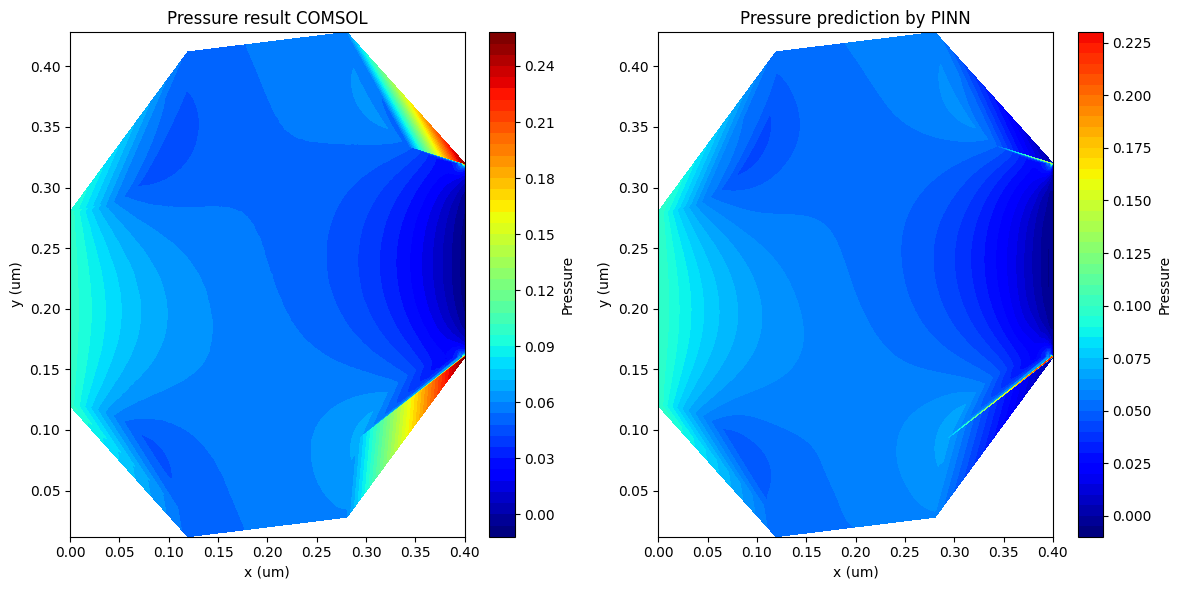

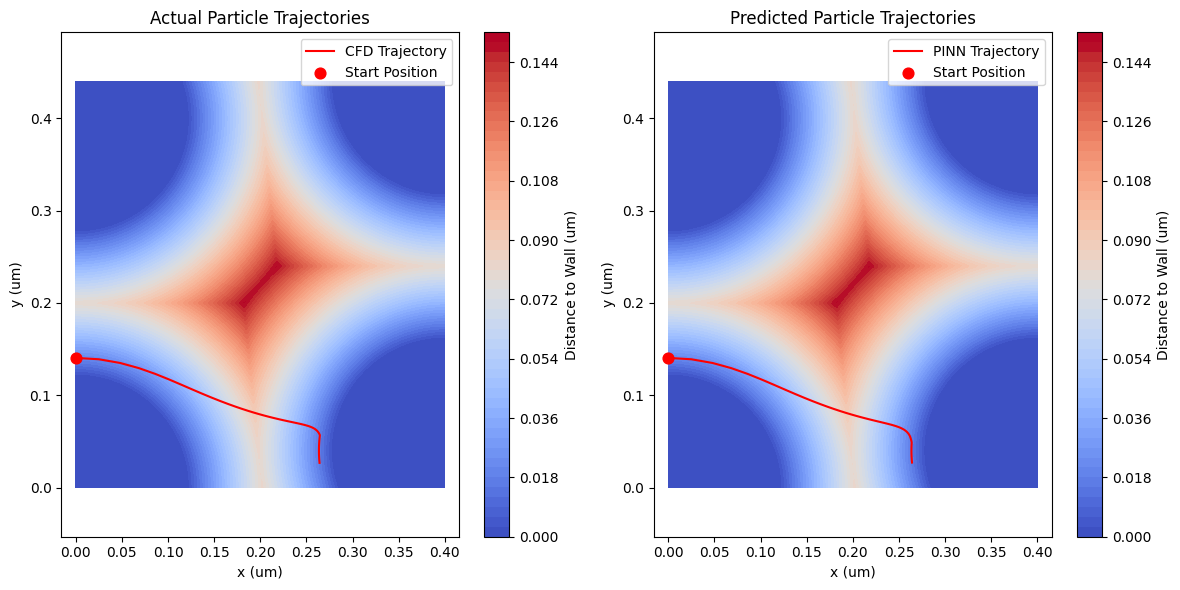

In [ ]:
# %%
# Load CSV file
df = pd.read_csv(file_cfd)
dff = pd.read_csv(file_pinn)

# Ensure the correct columns are selected for input
input_data = df.iloc[:, [0, 1, 5, 7]].values  # Selecting columns (x, y, d, N)
output_data = df.iloc[:, [2, 3, 4]].values  # Selecting columns (u, v, p)

# Ensure the correct columns are selected for input
input_dataf = dff.iloc[:, [0, 1]].values  # Selecting columns (x, y, d, N)
output_dataf = dff.iloc[:, [2, 3, 4]].values  # Selecting columns (u, v, p)

x_grid = input_data[:, 0].reshape(-1)
y_grid = input_data[:, 1].reshape(-1)
v_actual_grid = output_data[:, 1].reshape(-1)
v_pred_grid = output_dataf[:, 1].reshape(-1)
u_actual_grid = output_data[:, 0].reshape(-1)
u_pred_grid = output_dataf[:, 0].reshape(-1)
p_actual_grid = output_data[:, 2].reshape(-1)
p_pred_grid = output_dataf[:, 2].reshape(-1)

# Determine the common range for colorbar
vmin = min(u_actual_grid.min(), u_pred_grid.min())
vmax = max(u_actual_grid.max(), u_pred_grid.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual u-velocity
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, u_actual_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u (um/s)')
plt.title('Actual U')
plt.xlabel('x')
plt.ylabel('y')

# Predicted u-velocity
plt.subplot(1, 2, 2)
plt.tricontourf(x_grid, y_grid, u_pred_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u (um/s)')
plt.title('Predicted U')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()

# Save the figure
plt.savefig(f"results/U_comparison.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()

# Determine the common range for colorbar
vmin = min(v_actual_grid.min(), v_pred_grid.min())
vmax = max(v_actual_grid.max(), v_pred_grid.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual u-velocity
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, v_actual_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='v (um/s)')
plt.title('Actual V')
plt.xlabel('x (um)')
plt.ylabel('y (um)')

# Predicted u-velocity
plt.subplot(1, 2, 2)
plt.tricontourf(x_grid, y_grid, v_pred_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='v (um/s)')
plt.title('Predicted V')
plt.xlabel('x (um)')
plt.ylabel('y (um)')

plt.tight_layout()

# Save the figure
plt.savefig(f"results/V_comparison.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()

# Determine the common range for colorbar
vmin = min(p_actual_grid.min(), p_pred_grid.min())
vmax = max(p_actual_grid.max(), p_pred_grid.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual pressure
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, p_actual_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='Pressure')
plt.title('Actual Pressure')
plt.xlabel('x (um)')
plt.ylabel('y (um)')

# Predicted pressure
plt.subplot(1, 2, 2)
plt.tricontourf(x_grid, y_grid, p_pred_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='Pressure')
plt.title('Predicted Pressure')
plt.xlabel('x (um)')
plt.ylabel('y (um)')

plt.tight_layout()

# Save the figure
plt.savefig(f"results/P_comparison.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()

# Determine the common range for colorbar
vmin = distances.min()
vmax = distances.max()

# Plotting the trajectory
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
contour = plt.contourf(X, Y, distances, levels=50, cmap='coolwarm', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(contour)
cbar.set_label('Distance to Wall (um)')
plt.plot(x_cfd, y_cfd, 'r-', label='CFD Trajectory')
plt.scatter([x_cfd[0]], [y_cfd[0]], color='red', s=60, marker='o', label='Start Position')
plt.title('Actual Particle Trajectories')
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.legend()
plt.axis('equal')

plt.subplot(1, 2, 2)
contour = plt.contourf(X, Y, distances, levels=50, cmap='coolwarm', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(contour)
cbar.set_label('Distance to Wall (um)')
plt.plot(x_pinn, y_pinn, 'r-', label='PINN Trajectory')
plt.scatter([x_cfd[0]], [y_cfd[0]], color='red', s=60, marker='o', label='Start Position')
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.title('Predicted Particle Trajectories')
plt.legend()
plt.axis('equal')

plt.tight_layout()

plt.savefig(f"results/trajectory_comparison.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()

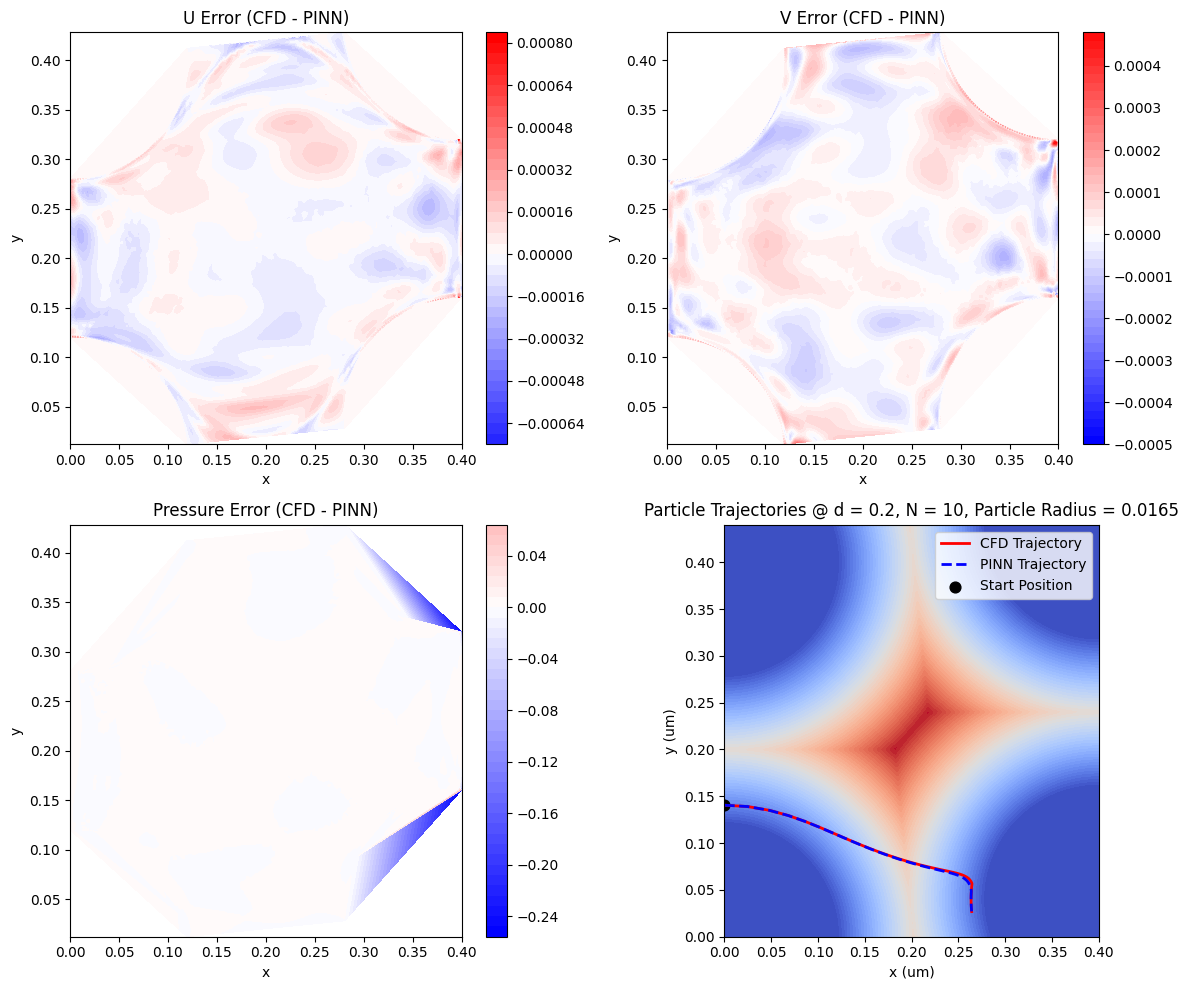

In [15]:
# Create error arrays
error_u = u_pred_grid - u_actual_grid
error_v = v_pred_grid - v_actual_grid
error_p = p_pred_grid - p_actual_grid

# Set color limits symmetrically for diverging colormap
err_lim_u = np.max(np.abs(error_u))
err_lim_v = np.max(np.abs(error_v))
err_lim_p = np.max(np.abs(error_p))

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# u-velocity error
cf1 = axs[0, 0].tricontourf(
    x_grid, y_grid, error_u, levels=50, cmap='bwr',
    vmin=-err_lim_u, vmax=err_lim_u
)
fig.colorbar(cf1, ax=axs[0, 0])
axs[0, 0].set_title('U Error (CFD - PINN)')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')

# v-velocity error
cf2 = axs[0, 1].tricontourf(
    x_grid, y_grid, error_v, levels=50, cmap='bwr',
    vmin=-err_lim_v, vmax=err_lim_v
)
fig.colorbar(cf2, ax=axs[0, 1])
axs[0, 1].set_title('V Error (CFD - PINN)')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')

# pressure error
cf3 = axs[1, 0].tricontourf(
    x_grid, y_grid, error_p, levels=50, cmap='bwr',
    vmin=-err_lim_p, vmax=err_lim_p
)
fig.colorbar(cf3, ax=axs[1, 0])
axs[1, 0].set_title('Pressure Error (CFD - PINN)')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')

# Add trajectory plot to the fourth subplot
axs[1, 1].contourf(X, Y, distances, levels=50, cmap='coolwarm')
axs[1, 1].plot(x_cfd, y_cfd, 'r-', label='CFD Trajectory', linewidth=2)
axs[1, 1].plot(x_pinn, y_pinn, 'b--', label='PINN Trajectory', linewidth=2)
axs[1, 1].scatter([x_cfd[0]], [y_cfd[0]], color='black', s=60, marker='o', label='Start Position')
axs[1, 1].set_xlabel('x (um)')
axs[1, 1].set_ylabel('y (um)')
axs[1, 1].set_title('Particle Trajectories @ d = {:.1f}, N = {}, Particle Radius = {}'.format(F * ds, N, radius_of_particle))
axs[1, 1].legend()
axs[1, 1].set_aspect('equal')

# Layout and save
plt.tight_layout()
plt.savefig("results/Comparison.png", dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# Compute MSE using NumPy
mse_u = np.mean((u_pred_grid - u_actual_grid)**2)
print(f"Mean Squared Error for u-component: {mse_u}")

# Compute MSE using NumPy
mse_v = np.mean((v_pred_grid - v_actual_grid)**2)
print(f"Mean Squared Error for v-component: {mse_v}")

# Compute MSE using NumPy
mse_p = np.mean((p_pred_grid - p_actual_grid)**2)
print(f"Mean Squared Error for p-component: {mse_p}")

Mean Squared Error for u-component: 4.783228689847734e-09
Mean Squared Error for v-component: 2.82145163621465e-09
Mean Squared Error for p-component: 3.7217146314752536e-05
